# Build a model to classify topics for Telegram channels

**Pre-req**
1. Download csv from gdrive with channels and save to ``data/external/telegram_channels.csv``
2. Run ``python -m src.train.download`` to get posts and meta-data

**Steps**
1. Load data:
    - posts from channels
    - channel titles and descriptions
    - channel topics
2. Build a training dataset:
    1. Merge
    2. Select inputs
    3. Split into train/val
3. Build models:
    1. Embed text
    2. Train a classifier
    3. Select best
4. Evaluate on test data and save best

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
#standard libs
import os, sys
from pathlib import Path
from pprint import pprint
from collections import Counter
import random
import json
import itertools
from datetime import datetime as dt
import logging
# ds libs
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm

from torchtext import data
import re
# custom path
os.chdir('../..')
os.environ['KMP_DUPLICATE_LIB_OK']='True'


In [2]:
from src.train.data_utils import flatten_category, load_data, select_test

## Data prep

In [3]:
DATA = 'data/interim/train_data.csv'

TEST_SIZE = 0.33
TEST_SETS = ['r-1', 'r-2']

### Load

In [4]:
data = load_data(DATA)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34130 entries, 0 to 34129
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   title              34130 non-null  object 
 1   description        34130 non-null  object 
 2   recent_posts       34130 non-null  object 
 3   lang_code          34130 non-null  object 
 4   id                 1491 non-null   float64
 5   category           34130 non-null  object 
 6   subset             34130 non-null  object 
 7   language           1138 non-null   object 
 8   topic [Primary]    1138 non-null   object 
 9   topic [Secondary]  222 non-null    object 
 10  primary            1138 non-null   object 
 11  secondary          1138 non-null   object 
 12  text               34130 non-null  object 
dtypes: float64(1), object(12)
memory usage: 3.4+ MB


In [5]:
LANGS = data['lang_code'].unique()

### Split

take a percentage for testing from selected subsets

In [6]:
data['subset'].value_counts()

tg      31501
chan     1138
r-2       800
r-1       691
Name: subset, dtype: int64

In [7]:
data['is_test'] = select_test(data, test_size=TEST_SIZE, test_subsets=TEST_SETS)

data.groupby(['lang_code','subset']).agg({'is_test': ['mean','count']})

is_test       
                      mean  count
lang_code subset                 
ar        chan    0.000000     99
          r-2     0.343137    204
en        chan    0.000000    313
          r-1     0.395062    324
          r-2     0.329670     91
          tg      0.000000  14775
fa        chan    0.000000    120
          r-2     0.333333    195
ru        chan    0.000000    471
          r-1     0.316076    367
          r-2     0.291262    103
          tg      0.000000  16726
uz        chan    0.000000    135
          r-2     0.352657    207

In [8]:
train_data = data.loc[~data['is_test']]

test_data = data.loc[data['is_test']]

print(train_data.shape)
print(test_data.shape)

(33618, 14)
(512, 14)


### Flatten train data

Create each category as a separate row, since sklearn can't handle multi-prob

In [9]:
train_data_flat = flatten_category(train_data,)

train_data_flat.shape

rows: 0it [00:00, ?it/s]

(69409, 16)

In [10]:
mapping = {t:t for t in train_data_flat['topic'].tolist()}
mapping.update({
    'Hacked Accounts': 'Hacked Accounts & Software',
    "Motivation & Self-Development": "Motivation & Self-development",
    "Foreign Languages": "Foreign Language Learning",
    
},)

train_data_flat['topic'] = train_data_flat['topic'].map(mapping,)

### Topic distribution

In [11]:
from src.train.plot_utils import barplots

ru


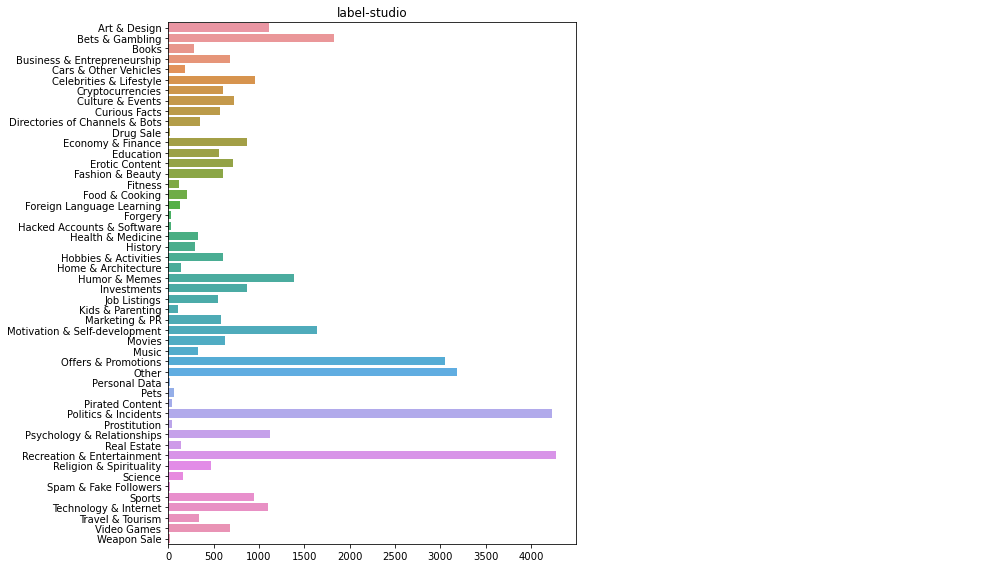

en


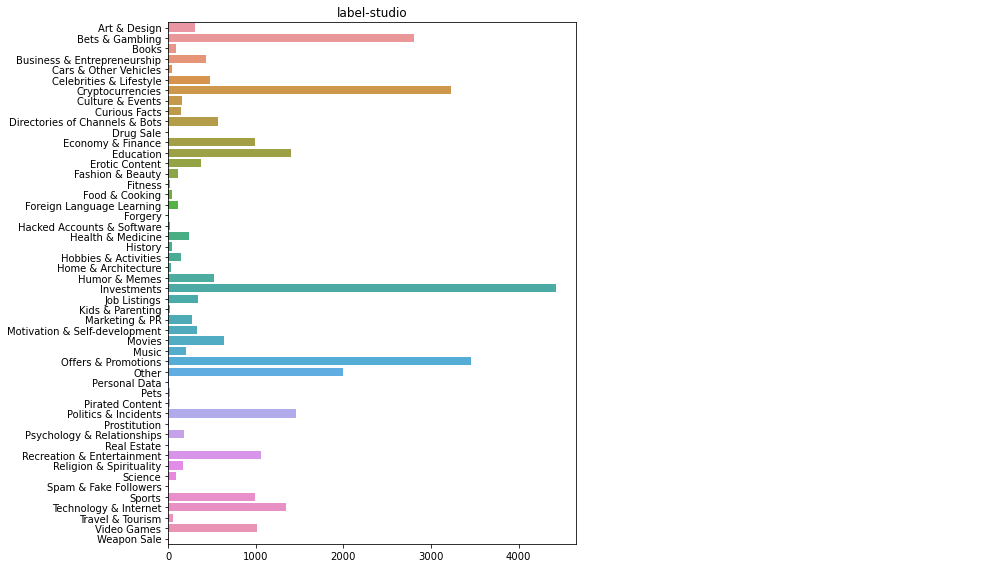

ar


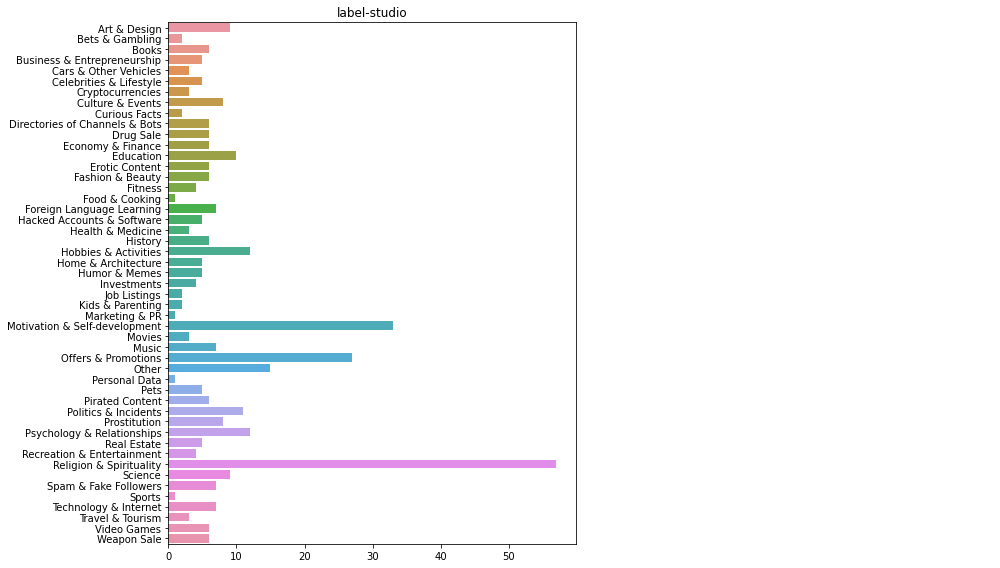

uz


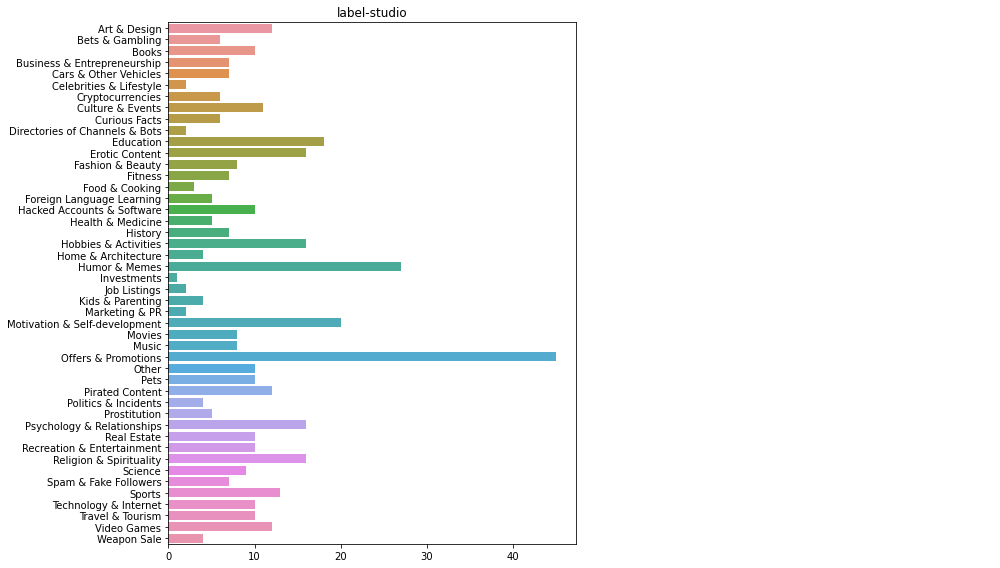

fa


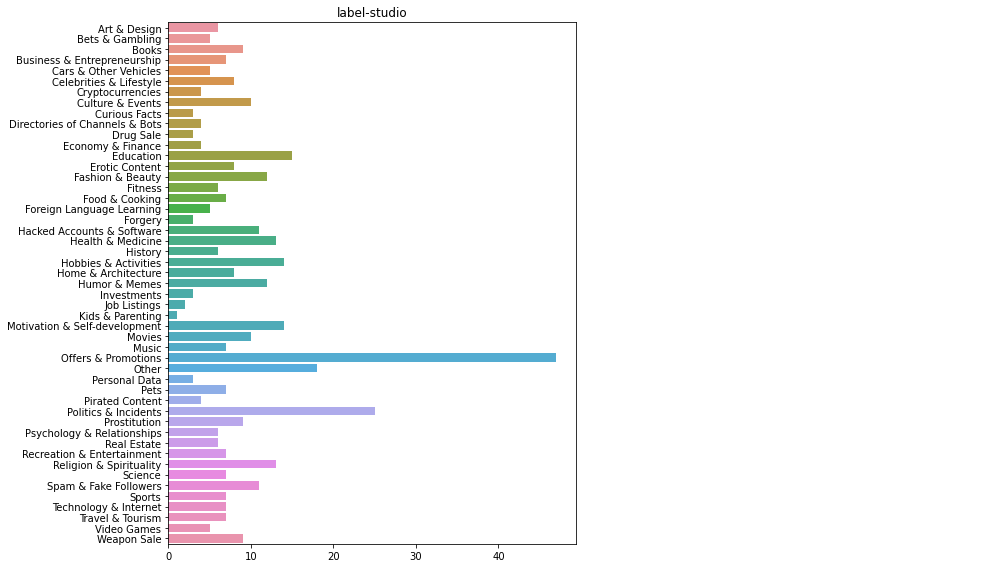

In [12]:
for l in train_data_flat['lang_code'].unique():
    print(l)
    barplots({
        'label-studio': train_data_flat.query(f"lang_code == '{l}'")['topic'],
    }, 1, 2, fig_dims=(14,8),)

In [15]:
print('Unique topics per language')
print(train_data_flat.groupby('lang_code')['topic'].nunique())

Unique topics per language
lang_code
ar    49
en    50
fa    49
ru    50
uz    46
Name: topic, dtype: int64


before

ar    45
en    50
fa    49
ru    50
uz    43

#### Delete

In [16]:
all_topics = train_data_flat['topic'].unique()

lang_topics = train_data_flat.query('lang_code == "uz"')['topic'].unique()

np.setdiff1d(all_topics, lang_topics)

array(['Drug Sale', 'Economy & Finance', 'Forgery', 'Personal Data'],
      dtype=object)

### Load stopwords

In [17]:
STOPWORDS = {
    'en': 'data/external/en_stopwords.txt',
    'ru': 'data/external/ru_stopwords.txt',
    'ar': 'data/external/ar_stopwords.txt',
    'fa': 'data/external/fa_stopwords.txt',
}

In [18]:
stopwords = [Path(f).read_text().strip().split('\n') for l,f in STOPWORDS.items()]

stopwords = sum(stopwords, [])

len(stopwords)

2050

## Experiments

**Improve:**
- [x] one common split for train and test
- [x] don't flatten test
- [ ] ~~cross-val when training~~
- [x] weighted metric
- [ ] ~~top-k accuracy metric~~
- [x] train on full set before saving

**Hyper-parameters:**
- [x] topics: primary only, primary + secondary
- [x] inputs: title, description, posts
- [x] preprocessing: raw, lemmas
- [x] vectorizers: tf-idf, bow
- [x] clf: xgb, nb, etc.
- [x] datasets {tg, r-1, r-2}
- [x] ngrams, chars vs words
- [ ] use new data types

In [19]:
from sklearn.model_selection import train_test_split

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.multioutput import MultiOutputClassifier, ClassifierChain
from sklearn.preprocessing import MultiLabelBinarizer, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression, ElasticNet
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix, top_k_accuracy_score
from sklearn.tree import ExtraTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.naive_bayes import ComplementNB, MultinomialNB

from xgboost import XGBClassifier

import itertools

In [20]:
import torch

from src.train.text_utils import tokenize_text
from src.train.neural import EmbeddingNet, load_vectors

In [21]:
class ScikitEmbeddingNet(EmbeddingNet):
    """ adapt embedding net to be used with scikit-learn classifiers """
    def __init__(self, filepath):
        self.file = filepath
        self.scaler = MinMaxScaler()
    
    
    def fit(self, X_data):
        vocab,dim = load_vectors(self.file)
        super().__init__(vocab, dim,)
    
    
    def transform(self, X_data):
        with torch.no_grad():
            tokenized = list(map(tokenize_text, X_data))
            x_vectors = self.forward(tokenized)
            x_features = self.get_batch_extremes(x_vectors)
        x_features = x_features.numpy()
        x_features = self.scaler.fit_transform(x_features)
        return x_features
    
    
    def fit_transform(self, X_data):
        self.fit(X_data)
        transformed = self.transform(X_data)
        return transformed
    
    
    def set_params(self, **kwargs):
        pass

In [22]:
class Trainer:
    """ prapre inputs, vectorize texts and run a classifier """
    def __init__(self, lang_code, subsets, vect, est, vect_params={}):
        self.LANG = lang_code
        query = f"lang_code == {lang_code!r} and subset == {subsets}"
        self.train_inputs = train_data_flat.query(query).copy()
        self.test_inputs = test_data.query(query).copy()
        self.vect = VECTORIZERS[vect]
        if vect_params != {}:
            self.vect.set_params(**vect_params)
        self.vect.preprocessor = lambda x: x
        self.vect.lowercase = False
        self.clf = ESTIMATORS[est]
        preprocessing = 'raw'
        assert preprocessing in ['lemma', 'raw']
        self.preprocessing = preprocessing
        if preprocessing == 'lemma':
            self.vect.tokenizer = lang_lemmatizer(lang_code)
        else:
            self.vect.tokenizer = tokenize_text
        
        
    def prepare_data(self, is_final):
        # for research use train data for fitting and test for eval
        if is_final:
            test_flat = flatten_category(self.test_inputs)
            self.y_train = self.train_inputs['topic'].append(test_flat['topic'])
            self.X_train = self.vect.fit_transform(self.train_inputs['text'].append(test_flat['text']))
            self.sample_weights = self.train_inputs['weight'].append(test_flat['weight'])
        else:
            self.y_train = self.train_inputs['topic']
            self.X_train = self.vect.fit_transform(self.train_inputs['text'])
            self.sample_weights = self.train_inputs['weight']
        self.X_test = self.vect.transform(self.test_inputs['text'])
            
    
    def train(self):
        try:
            self.clf.fit(self.X_train, self.y_train, sample_weight=self.sample_weights)
        except TypeError as e:
            logging.warning(e.args[0])
            self.clf.fit(self.X_train, self.y_train)
        
        
    def run_eval(self, final=False):
        """ prepare inputs and run clf evaluation """
        self.prepare_data(final)
        self.train()
        predicted = trainer.clf.predict_proba(trainer.X_test)
        scores = score_predictions(trainer.test_inputs['category'], predicted, self.clf.classes_)
        return np.mean(scores)
    

def calc_weight_score(topic_weights, predicted_probs, classes):
    true_weights = np.zeros(len(classes))
    for t,w in topic_weights.items():
        index = np.argwhere(classes == t).squeeze()
        true_weights[index] = w
    mae = round(sum(abs(true_weights - predicted_probs)),4)
    return 1 / (1 + mae)


def score_predictions(true_topics, predicted_probs, classes):
    scores = list(map(lambda x: calc_weight_score(x[0],x[1],classes),
                         zip(true_topics, predicted_probs)))
    return scores

### Set hyper-parameters

In [23]:
SUBSETS = [
#     ('r-2', 'r-1', 'chan'),
#     ('r-2', 'r-1'),
#     ('r-2', 'chan'),
    ('r-2', 'r-1', 'chan', 'tg'),
]

vect_params = dict(
    max_df=0.4, 
    min_df=3,
    max_features=2000,
    binary=False, 
    ngram_range=(1,1), 
    tokenizer=tokenize_text,
    stop_words=stopwords, 
    analyzer='word'
)
vect_space = [
    dict(max_features=2000,),
    dict(max_features=3000,),
]
VECTORIZERS = {
#     'tfidf': TfidfVectorizer(**vect_params),
    'bow': CountVectorizer(**vect_params),
#     'fasttext' : ScikitEmbeddingNet('models/external/word_vectors/100k.cc.en.300.vec'),
}


ESTIMATORS = dict(
#     xgb = XGBClassifier(objective='multi:softmax'),
#     forest = RandomForestClassifier(),
#     logreg = LogisticRegression(),
#     knn = KNeighborsClassifier(),
#     tree = ExtraTreeClassifier(),
#     svm = SVC(),
#     linsvm = LinearSVC(),
#     cnb = ComplementNB(),
    mnb = MultinomialNB(),
)

In [24]:

train_params = list(itertools.product(
    LANGS, 
    SUBSETS,
    VECTORIZERS.keys(), 
    ESTIMATORS.keys(),
    vect_space,
))

print(f'{len(train_params)} experiments to run')

10 experiments to run


#### Test trainer

In [25]:
trainer = Trainer(
    lang_code = 'fa', 
    subsets = SUBSETS[0],
    vect = 'bow', 
    est = 'mnb',
    vect_params={'max_features': 2001, 'min_df': 4}
)
s = trainer.run_eval(final=False)
print(s)

/Users/rustem.galiullin/miniconda3/envs/tgcat/lib/python3.7/site-packages/sklearn/feature_extraction/text.py:391: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['cent', 'dr', 'mr', 'per', 'آسانی', 'آسیب', 'أخير', 'أسبوع', 'أفضل', 'أول', 'إعلام', 'اثر', 'احیانا', 'اخیرا', 'ازاین', 'اسلامی', 'اطلاعند', 'الاسف', 'الظاهر', 'بااین', 'بازی', 'باوجودی', 'برآن', 'برنامه', 'بسته', 'بطوری', 'بفهمی', 'بلد', 'تازگی', 'تحریم', 'تدریج', 'ترتیب', 'تردید', 'ترند', 'تصریحا', 'تفاوتند', 'تند', 'توؤما', 'تول', 'تک', 'ثالثا', 'ثاني', 'ثانی', 'جانب', 'جديد', 'جزء', 'جمع', 'جمعة', 'جمله', 'جميع', 'جنس', 'جوری', 'حاشیه', 'حالي', 'حسابی', 'حکما', 'خارج', 'خسته', 'خميس', 'خوبی', 'خودبه', 'خودی', 'دائم', 'داند', 'دراین', 'درحالی', 'درشتی', 'درصورتی', 'درعین', 'درپی', 'دسته', 'دلخواه', 'دنبال', 'دیوانه', 'ذاتا', 'ذلک', 'راجع', 'رسد', 'رغم', 'رود', 'روزه', 'روشنی', 'رويترز', 'زده', 'زودی', 'ساده', 'سادگی', 'سازهاست', 'ساعة', 'سالم', 'ساله', 'س

0.5816512061411031


### Run experiments

In [26]:
results = []

for params in tqdm(train_params, desc='# experiments'):
    trainer = Trainer(*params)
    score = trainer.run_eval()
    params += (score,)
    results.append(params)
                
results = pd.DataFrame(results, columns=['lang_code','subsets','vect', 'est', 'vect_params','score',])

# experiments:   0%|          | 0/10 [00:00<?, ?it/s]

### Show results

In [27]:
for l in results['lang_code'].unique():
    one = results.query(f'lang_code == "{l}"').sort_values('score', ascending=False)
    
    print(one.to_markdown(), end='\n\n')

|    | lang_code   | subsets                      | vect   | est   | vect_params            |    score |
|---:|:------------|:-----------------------------|:-------|:------|:-----------------------|---------:|
|  1 | ru          | ('r-2', 'r-1', 'chan', 'tg') | bow    | mnb   | {'max_features': 3000} | 0.668015 |
|  0 | ru          | ('r-2', 'r-1', 'chan', 'tg') | bow    | mnb   | {'max_features': 2000} | 0.65659  |

|    | lang_code   | subsets                      | vect   | est   | vect_params            |    score |
|---:|:------------|:-----------------------------|:-------|:------|:-----------------------|---------:|
|  3 | en          | ('r-2', 'r-1', 'chan', 'tg') | bow    | mnb   | {'max_features': 3000} | 0.65308  |
|  2 | en          | ('r-2', 'r-1', 'chan', 'tg') | bow    | mnb   | {'max_features': 2000} | 0.631558 |

|    | lang_code   | subsets                      | vect   | est   | vect_params            |    score |
|---:|:------------|:-----------------------------|:-

In [28]:
print(results.groupby('lang_code').agg({'score':'max'}).to_markdown())

| lang_code   |    score |
|:------------|---------:|
| ar          | 0.584847 |
| en          | 0.65308  |
| fa          | 0.598246 |
| ru          | 0.668015 |
| uz          | 0.48394  |


**after fixing topic issue**

| lang_code   |    score |
|:------------|---------:|
| ar          | 0.537213 |
| en          | 0.656156 |
| fa          | 0.566891 |
| ru          | 0.641199 |
| uz          | 0.458695 |



**with max-features 3000**

| lang_code   |    score |
|:------------|---------:|
| ar          | 0.542047 |
| en          | 0.660576 |
| fa          | 0.592046 |
| ru          | 0.665547 |
| uz          | 0.510825 |


### Review errors

#### Train

In [82]:
trainer = Trainer(
    lang_code = 'uz', 
    subsets = SUBSETS[0],
    vect = 'bow', 
    est = 'mnb'
)
s = trainer.run_eval(final=False)
print(s)

print(f'vocab size: {len(trainer.vect.vocabulary_)}')

0.5108249862411709
vocab size: 3000


In [83]:
test_pred = trainer.clf.predict_proba(trainer.X_test)

# is_wrong = test_pred != trainer.y_test

errors = trainer.test_inputs.copy()

errors['score'] = score_predictions(errors['category'], test_pred, trainer.clf.classes_)

#### random examples

In [84]:
def get_top_classes(probs, classes):
    top_inds = np.argwhere(probs > probs.mean()).squeeze(1)
    return Counter({classes[i]:probs[i] for i in top_inds})

In [88]:
i = random.randint(0, len(errors)-1)
row = errors.iloc[i]
pred = get_top_classes(test_pred[i], trainer.clf.classes_)

# print('PREDICTED:\n', row['predicted'], end='\n\n')
print('MAE:\n', row['score'], end='\n\n')
print('TRUE:\n', row['category'], end='\n\n')
print('PREDICTED:\n', pred, end='\n\n')
print('TEXTS:\n', row['text'], end='\n\n')
# print(f'TITLE ({row["id"]}):\n', row['title'], end='\n\n')
# print('DESCRIPTION:\n', row['description'], end='\n\n')

MAE:
 0.9629272989889264

TRUE:
 {'Religion & Spirituality': 1.0}

PREDICTED:
 Counter({'Religion & Spirituality': 0.9807554724163344})

TEXTS:
 NAMOZXONLAR
بِسْــــــــــــــــــــــمِ ﷲِالرَّحْمَنِ الرَّحِيم

✅ SIZ BU YERDA NAMOZ HAQIDA BATAFSIL MA’LUMOTLAR OLISHINGIZ MUMKIN.

⏰ SHUNINGDEK, KUNLIK NAMOZ VAQTLARI VA MA'RUZALAR BERIB BORILADI

Reklama uchun @REKXONA
menejer 👉🏼 @Mexir_siz
🌙 Yaqinlashayotgan Ramazon muborak boʻlsin

🖼Ismingiz yozilgan Ramazon tabrik rasmlarni profilingizga quyib olishni istaysizmi?

👨‍💻Unda botimiz orqali ismingizni yozib oling👇
@RamazonTabriklariBot

💫 Yaqinlaringizga xam ulashib, ularni xursand qiling😇
🔥 БЕНАМОЗЛИК 🔥

🔥 Дўзах аҳлидан «Сизларни дўзахга нима киритди?» (Муддассир сураси, 42-оят) деб сўралса, улар шундай жавоб беришади: «Намоз ўқийдиганлардан бўл-маган эдик» (Муддассир сураси, 43-оят) дерлар.


✿•┈•┈•┈•┈•┈•┈•┈•┈•┈•✿🌙
🌴Жаннатда ёнингизда бўлишини истаган яқинларингизга #улашинг🌴 
✿•┈•┈•┈•┈•┈•┈•┈•┈•┈•✿🌙

🌸 @namozHD 🌸
➥ Каналга уланинг!👇🏼
htt

#### Fixes

**fixes**
- [ ] update stopwords: fa/uz
- [x] lemmas
- [x] remove single char terms
- [x] compare feature keywords against topic keywords
- [x] multi-class problem
- [x] only eng and rus chars
- [x] measure accuracy with top N predictions
- [x] use full data to train last
- [x] sample weights for secondary
- [x] bow to torchscript
- [x] apply sum normalization only then min prob threshold
- [x] fix when nothing predicted (add zero vectors as Other)
- [x] remove URL for lang detection

## Save models

In [29]:
from torch import nn
import torch
from torch.nn import functional as F
from typing import Dict, List, Tuple

In [30]:
class NaiveBayes(nn.Module):
    """ Implement Multinomial and Complement NB inference """
    def __init__(self, nb, clf,):
        super().__init__()
        assert nb in ['cnb','mnb']
        self.nb = nb
        self.feature_log_prior = nn.Parameter(torch.tensor(clf.feature_log_prob_), requires_grad=False)
        self.class_log_prior = nn.Parameter(torch.tensor(clf.class_log_prior_), requires_grad=False)
        self.class_labels = clf.classes_.tolist()
        

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        jll = torch.matmul(x.double(), self.feature_log_prior.T)
        if self.nb == 'cnb':
            if self.class_log_prior.size(0) == 1:
                jll += self.class_log_prior
        else:
            jll += self.class_log_prior
        log_prob = torch.logsumexp(jll, dim=1)
        log_prob = jll - torch.atleast_2d(log_prob).T
        prob = torch.exp(log_prob)
        return prob


class TextVectorizer(nn.Module):
    """ vectorize text using tf-idf or bow """
    def __init__(self, vect, vectorizer):
        super().__init__()
        assert vect in ['bow','tfidf']
        self.vocab = {k: torch.tensor(v) for k,v in vectorizer.vocabulary_.items()}
        self.vocab_len = len(self.vocab)
        if vect == 'tfidf':
            self.idf_diag = nn.Parameter(
                torch.tensor(vectorizer._tfidf._idf_diag.toarray()), 
                requires_grad=False)
            self.sublinear_tf = vectorizer.sublinear_tf
            self.norm = vectorizer.norm
            self.use_idf = vectorizer.use_idf
        else:
            self.idf_diag = nn.Parameter(torch.eye(self.vocab_len))
            self.sublinear_tf = False
            self.norm = None
            self.use_idf = False
            
        

    def count_vocab(self, doc: List[str]) -> torch.Tensor:
        """ return counts of each word from the vocab """
        feature_counter = torch.zeros(self.vocab_len, dtype=torch.long)
        for feature in doc:
            n = self.vocab.get(str(feature), torch.tensor(-1))
            if n.item() != -1:
                feature_idx = self.vocab[str(feature)]
                feature_counter[feature_idx] += 1
        return feature_counter
        
        
    def forward(self, batch: List[List[str]]) -> torch.Tensor:
        doc_counts: List[torch.Tensor] = [self.count_vocab(doc) for doc in batch]
        X = torch.stack(doc_counts,)
        if self.sublinear_tf:
            X = torch.log(X.double())
            X += 1
        if self.use_idf:
            X = torch.matmul(X.double(), self.idf_diag)
        if self.norm is not None:
            p = float(self.norm[-1])
            X = F.normalize(X.double(), p=p, dim=1)
        return X
    

class TgCat(nn.Module):
    """ vectorize input texts, classfy topics and decode predictions """
    def __init__(self, vect, clf, top_k=3,):
        super().__init__()
        self.vect = vect
        self.clf = clf
        self.top_k = top_k
        
        
    def select_top_classes(self, probs: torch.Tensor) -> Dict[str,float]:
        """ select classes with at least min prob and return a normalized dict mapping """
        if self.clf.nb == 'cnb':
            if probs.std(0) < 0.0001:
                return {"Other": 1.0}
        else:
            if probs.max() < 0.1:
                return {"Other": 1.0}
        inds_desc = torch.argsort(probs, 0, descending=True)
        top_k = min((probs > probs.mean()).sum(), torch.tensor(self.top_k))
        target_i = inds_desc[:top_k]
        target_p = probs[target_i]
        target_p = target_p / target_p.sum()
        result: List[Tuple[str, float]] = [
            (self.clf.class_labels[target_i[i].item()], target_p[i].item())
            for i in range(target_p.size(0))
        ]
        return dict(result)
    
    
    def get_prob(self, batch: List[List[str]]) -> torch.Tensor:
        embeddings = self.vect(batch)
        probs = self.clf(embeddings)
        # for mnb, if empty embedding then zero out probs
        vec_sums = embeddings.sum(1).clip(0, 1)
        probs = probs * torch.atleast_2d(vec_sums).T
        return probs
        
    
    def forward(self, batch: List[List[str]]) -> List[Dict[str, float]]:
        probs = self.get_prob(batch)
        top_predictions = [self.select_top_classes(probs[i]) for i in range(probs.size(0))]
        return top_predictions

### Test

#### train one

In [179]:
V = 'bow'
E = 'mnb'
L = 'ru'

trainer = Trainer(
    lang_code = L,
    subsets=SUBSETS[0],
    vect = V, 
    est = E,
)
_ = trainer.run_eval(final=False)

tgcat = TgCat(TextVectorizer(V, trainer.vect), NaiveBayes(E, trainer.clf), top_k=3)

#### random batch

In [180]:

batch = trainer.test_inputs['text'].apply(tokenize_text).tolist()

predictions = tgcat(batch)

In [181]:
i = random.randint(0, len(batch) - 1)

print('PREDICTED', predictions[i], end='\n\n')
print('TOKENS', batch[i])

PREDICTED {'History': 0.9023038117045685, 'Politics & Incidents': 0.05305718817067863, 'Books': 0.04463900012475274}

TOKENS ['старше', 'эдды', 'для', 'связи', 'starsheeddy', 'bot', 'starsheeddy', 'gmail', 'com', 'дорогие', 'друзья', 'если', 'хотите', 'помочь', 'каналу', 'то', 'альфа', 'банк', 'тиньков', 'поступают', 'сообщения', 'что', 'российские', 'миротворцы', 'остановили', 'близ', 'капана', 'юг', 'армении', 'не', 'меру', 'ретивых', 'азербайджанских', 'аскяров', 'армия', 'собственно', 'армении', 'давным', 'давно', 'горделиво', 'самоустранилась', 'от', 'подобных', 'мелочей', 'медитирует', 'пытаясь', 'постичь', 'нирвану', 'если', 'бы', 'видели', 'здание', 'минобороны', 'армении', 'или', 'побродили', 'по', 'его', 'кабинетам', 'то', 'вашему', 'разуму', 'привиделась', 'бы', 'такая', 'картина', 'наверняка', 'армия', 'этой', 'страны', 'владеет', 'дивизиями', 'титанов', 'космическое', 'пространство', 'прикрывают', 'сотни', 'тяжелых', 'звездолетов', 'могучими', 'лазерными', 'орудиями', 'спо

#### with trash

In [182]:
trash = [['a','s','d'], [""], ["other", 'other', 'ttt'], ["чгк", "нияег", "его"]]

trash_out = tgcat(trash)

for out in trash_out:
    assert out.get('Other', 0) > 0.5, out
    
logging.info('Passed Other test')

### Final training, convert and save

In [31]:
from sklearn.preprocessing import normalize

In [32]:
prediction_params = {
    'top_k': 3
}

In [33]:
for l in results['lang_code'].unique():
    subset = results.query(f"lang_code == '{l}'")
    best_id = subset['score'].idxmax()
    best_params = subset.loc[best_id].to_dict()
    print(l, 'best', best_params)
    del best_params['score']
    # for last training increase train by test
    trainer = Trainer(**best_params)
    s = trainer.run_eval(final=True)
    print(l, s)
    # save text vectorizer
    vect_scripted = torch.jit.script(TextVectorizer(best_params['vect'], trainer.vect), )
#     tokenizer = tokenize_text if best_params['preprocessing'] == 'raw' else lang_lemmatizer(l)
    tokenizer = tokenize_text
    batch = trainer.test_inputs['text'].apply(tokenizer).tolist()
    vect_out = vect_scripted(batch)
    src_vects = trainer.X_test.toarray()
    assert np.allclose(src_vects, vect_out.numpy())
    vect_scripted.save(f"models/trained/embed/{l}_{best_params['vect']}_script.pt")
    # save classifier
    nb_scripted  = torch.jit.script(NaiveBayes(best_params['est'], trainer.clf))
    nb_out = nb_scripted(torch.tensor(trainer.X_test.toarray(), dtype=torch.double))
    assert np.allclose(trainer.clf.predict_proba(trainer.X_test), nb_out.numpy())
    nb_scripted.save(f"models/trained/classify/{l}_{best_params['est']}_script.pt")
    # save tgcat
    tgcat = torch.jit.script(TgCat(vect_scripted, nb_scripted, **prediction_params))
    path = f'models/trained/tgcat/{l}_tgcat.pt'
    torch.jit.save(tgcat, path)
    print('saved to', path)

ru best {'lang_code': 'ru', 'subsets': ('r-2', 'r-1', 'chan', 'tg'), 'vect': 'bow', 'est': 'mnb', 'vect_params': {'max_features': 3000}, 'score': 0.6680150321386218}


rows: 0it [00:00, ?it/s]

ru 0.6857615733453514
saved to models/trained/tgcat/ru_tgcat.pt
en best {'lang_code': 'en', 'subsets': ('r-2', 'r-1', 'chan', 'tg'), 'vect': 'bow', 'est': 'mnb', 'vect_params': {'max_features': 3000}, 'score': 0.6530796624690406}


rows: 0it [00:00, ?it/s]

en 0.668136518893858
saved to models/trained/tgcat/en_tgcat.pt
ar best {'lang_code': 'ar', 'subsets': ('r-2', 'r-1', 'chan', 'tg'), 'vect': 'bow', 'est': 'mnb', 'vect_params': {'max_features': 2000}, 'score': 0.5848466750329474}


rows: 0it [00:00, ?it/s]

ar 0.7362956319829459
saved to models/trained/tgcat/ar_tgcat.pt
fa best {'lang_code': 'fa', 'subsets': ('r-2', 'r-1', 'chan', 'tg'), 'vect': 'bow', 'est': 'mnb', 'vect_params': {'max_features': 3000}, 'score': 0.5982460438916808}


rows: 0it [00:00, ?it/s]

fa 0.7625852902272539
saved to models/trained/tgcat/fa_tgcat.pt
uz best {'lang_code': 'uz', 'subsets': ('r-2', 'r-1', 'chan', 'tg'), 'vect': 'bow', 'est': 'mnb', 'vect_params': {'max_features': 2000}, 'score': 0.4839402070526259}


rows: 0it [00:00, ?it/s]

uz 0.7237342794732979
saved to models/trained/tgcat/uz_tgcat.pt


### Check file sizes

In [34]:
!du -hm models/trained/tgcat/* | sort -nr | grep -v '.dvc'

38	models/trained/tgcat/ru_tgcat.pt
38	models/trained/tgcat/fa_tgcat.pt
38	models/trained/tgcat/en_tgcat.pt
18	models/trained/tgcat/uz_tgcat.pt
18	models/trained/tgcat/ar_tgcat.pt


**Noticed on the last day**

1. Topic names have changed:
    - round-1: Motivation & Self-Development, Foreign Languages
    - round-2: Motivation & Self-development (D is lowercase), Foreign Language Learning
2. Error in flattening train data -> only last to topic from category was kept since i updated previous dicts
3. Docker `no space on device` issues
4. Telegram channel downloads fail because exceeding number of requests
5. `\n` not recognized during text tokenization